In [2]:
using Distributed
# nss=20
addprocs(20)

20-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21

In [3]:
nss=20

20

In [4]:
using Revise
using GeoPhyInv
using StatsBase
using Distributions
using Plots
using Conv
using DSP
using HDF5
using MLDataUtils
using Random
using ProgressMeter
# pgfplotsx()
gr()

Plots.GRBackend()

In [5]:
tgrid = range(0.0,stop=1.333,length=1000); # generate a time grid
nts=100
vp0 = [2500., 3500.] # bounds for vp
rho0 = [2500., 3500.] # density bounds
mgrid = repeat([range(-1000.0,stop=1000.0,length=211)],2)
nz,nx=length.(mgrid)

function get_mod(pert_flag)
    mod=Medium(mgrid,[:vp,:rho])
    GeoPhyInv.update!(mod,[:vp,:rho],[vp0,rho0])
    fill!(mod)
    GeoPhyInv.update!(mod, [:vp,:rho], constant_pert=-500.)
    # medium=deepcopy(medium0)  # not working, bugggy to NAN
    if(pert_flag==1)
        GeoPhyInv.update!(mod, [:vp,:rho], rect_loc=[-100,-100,300,300], rect_pert=1000.)
        mod=GeoPhyInv.Medium_smooth(mod,10,10)
    end
    return mod
end
medium0=get_mod(0)
	
w = ormsby(10.0, tgrid, tpeak=0.25,); 

ageom=AGeom(medium0.mgrid,:xwell, SSrcs(nss), Recs(100)); # load a simple acquisition using `mgrid` of the medium
rad=rand(Uniform(800,1000),nss)
theta=rand(Uniform(0,2*pi),nss)
for is in 1:nss
	GeoPhyInv.update!(ageom[is], Srcs(1), [0,0], rad[is], fill(theta[is],2))
end
GeoPhyInv.update!(ageom, Recs(100), [0,0], 600, [0, 2*pi] )
# GeoPhyInv.update!(ageom, SSrcs(20), [0,0], 0, fill(0,2))
srcwav = SrcWav(tgrid, ageom, [:p]);
wav = ormsby(10.0, tgrid, tpeak=0.25,); # ricker wavelet
GeoPhyInv.update!(srcwav, [:p], wav);

pa=SeisForwExpt(Fdtd(),medium=medium0, ageom=ageom, srcwav=srcwav,
	snaps_flag=false,tgrid=tgrid, verbose=false, rfields=[:p]);


In [6]:
medium0[:vp],medium0.bounds[:vp]


([2500.0 2500.0 … 2500.0 2500.0; 2500.0 2500.0 … 2500.0 2500.0; … ; 2500.0 2500.0 … 2500.0 2500.0; 2500.0 2500.0 … 2500.0 2500.0], [2500.0, 3500.0])

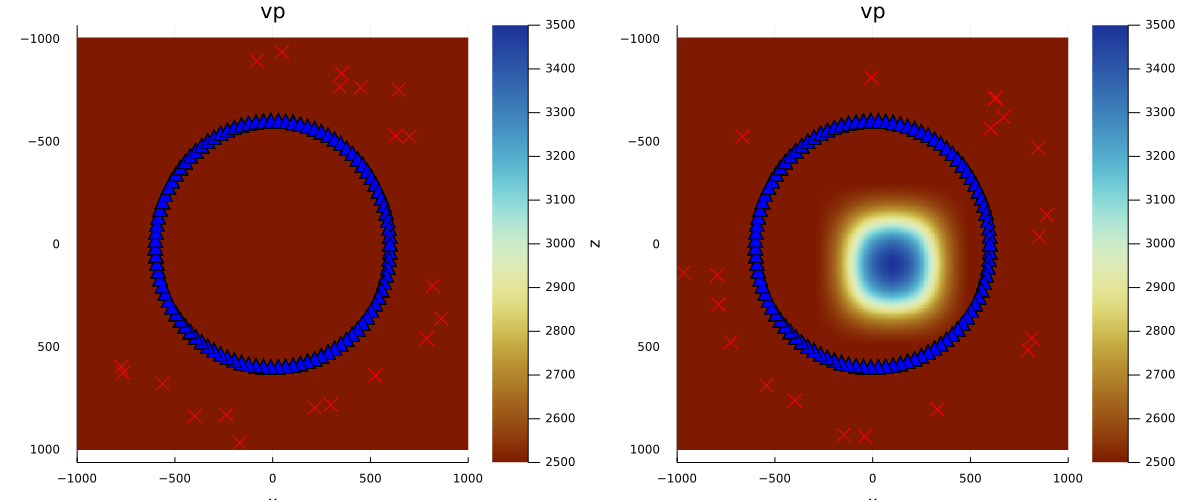

In [6]:
medium_pert_plot=get_mod(1)

ageom2=AGeom(medium0.mgrid,:xwell, SSrcs(nss), Recs(100)); # load a simple acquisition using `mgrid` of the medium
rad=rand(Uniform(800,1000),nss)
theta=rand(Uniform(0,2*pi),nss)
GeoPhyInv.update!(ageom2, Recs(100), [0,0], 600, [0, 2*pi] )
for is in 1:nss
	GeoPhyInv.update!(ageom2[is], Srcs(1), [0,0], rad[is], fill(theta[is],2))
end
p1=heatmap(medium_pert_plot)
scatter!(p1,ageom2, Recs())
scatter!(p1,ageom2, SSrcs())
p2=heatmap(medium0)
scatter!(p2,ageom, Recs())
scatter!(p2,ageom, SSrcs())
plot(p2,p1, size=(1200,500))


In [5]:
p1=heatmap(medium0, xaxis=nothing,yaxis=nothing,xlabel="", ylabel="", title="",colorbar=nothing, c=:viridis, size=(1000,1000))
savefig(p1,"vp_baseline.png")
p2=heatmap(medium_pert_plot, xaxis=nothing,yaxis=nothing,xlabel="", ylabel="", title="",colorbar=nothing, c=:viridis, size=(1000,1000))
savefig(p2,"vp_monitor.png")

In [7]:
function generate_and_store_data(pert_flag, rad, theta, wav, name)
	# GeoPhyInv.update!(medium, [:vp,:rh)o], randn_perc=5); # add some random noise to the medium
	# rad=rand(Uniform(800,1000))
	# theta=rand(Uniform(0,2*pi))
	medium=get_mod(pert_flag)
	GeoPhyInv.update!(pa,medium)
	for is in 1:nss
		GeoPhyInv.update!(ageom[is], Srcs(1), [0,0], rad[is], fill(theta[is],2))
	end

	GeoPhyInv.update!(pa,ageom)

	# p1=heatmap(medium, :vp)
	# scatter!(ageom, SSrcs())
	# scatter!(ageom, Recs())
	# plot(p1)
	# tgrid = range(0.0,stop=2.0,length=2000); # generate a time grid
	# wav = ormsby(10.0, tgrid, tpeak=0.25,); # ricker wavelet
	for is in 1:nss
		wavv=view(wav,:,is)
		GeoPhyInv.update!(srcwav[is], [:p], wavv);
	end
	GeoPhyInv.update!(pa, srcwav)

	GeoPhyInv.initialize!(pa.c)
	GeoPhyInv.update!(pa);

	for is in 1:nss
		# resampling
		data=pa[:data,is][:p]
		datanew=zeros(250,100)
		for i in 1:size(data,2)
			d=view(data,:,i)
			dd=view(datanew,:,i)
			ddd=resample(d,0.25)
			copyto!(dd,ddd)
		end
		datanew=datanew[51:210,:]
		ds=size(datanew)
		d=vec(datanew)
		rescale!(d)
		datanew=Float32.(reshape(d,ds...))
		# println(size(datanew))
		# return datanew
		h5open(string(name,".h5"),isfile(string(name,".h5")) ? "r+" : "w") do file
			g=create_group(file, string(randn()))
			g["data"] = datanew
			# g["wav"] = wav[:,is]
			g["rad"] = rad[is] 
			g["angle"] = theta[is]
			g["medium"] = pert_flag
		end
	end
end

generate_and_store_data (generic function with 1 method)

In [8]:

		GeoPhyInv.Utils.findfreq(wav,tgrid), inv(step(tgrid)), inv(step(tgrid))*0.25*0.5
    

(23.232558139534884, 749.437359339835, 93.67966991747937)

In [9]:
@showprogress for isamp in 1:500
	med=sample([0,1])
	rad=rand(Uniform(800,1000),nss)
	theta=rand(Uniform(0,2*pi),nss)
    wavv=[]
    for is in 1:nss
        a=randn(nts)
        wav=DSP.conv(a,w)[1:length(tgrid)]
        push!(wavv,wav)
    end
    wav=hcat(wavv...)
	generate_and_store_data(med, rad, theta, wav, "train_data")
end

In [33]:

	print(sample([1,2]))

0

In [8]:
# Xotest=zeros(Float32,1,200,100,20,2)
# @showprogress for itau in 1:20
# @showprogress for isamp in 1:10
    Random.seed!(1234);
    rad=vcat(fill(900,4),rand(Uniform(800,1000),nss-4))
    theta=vcat([pi/4,3*pi/4,5*pi/4,7*pi/4],rand(Uniform(0,2*pi),nss-4))
    # rad=rand(Uniform(800,1000),nss)
    # theta=rand(Uniform(0,2*pi),nss)
    wavv=[]
    for is in 1:nss
        a=randn(nts)
        wav=DSP.conv(a,w)[1:length(tgrid)]
        push!(wavv,wav)
    end
    wav=hcat(wavv...)
    for med in 0:1
        name=string("test",med,"data")
        rm(string(name,".h5"), force=true)
        generate_and_store_data(med, rad, theta, wav, string("test",med,"data"))
        # dd=view(Xotest,:,:,:,itau,icontent+1)
        # copyto!(dd,d)
    end
# end

# end

In [9]:
d=[]
rads1=[]
angles1=[]
h5open(string("test0data.h5"),"r") do file
    for f in file
        push!(d,Array(f["data"]))
        push!(rads1,Array(f["rad"]))
        push!(angles1,Array(f["angle"]))
    end
end
I0=[findall(x->x==k,angles1)[1] for k in [pi/4,3pi/4,5pi/4,7pi/4]]
I=sortperm(rads1)
data0=cat(d...,dims=3)
data0=data0[:,:,vcat(I0,filter!(a->a ∉ I0,I))]


d=[]
rads2=[]
angles2=[]
h5open(string("test1data.h5"),"r") do file
    for f in file
        push!(d,Array(f["data"]))
        push!(rads2,Array(f["rad"]))
        push!(angles2,Array(f["angle"]))
    end
end
I0=[findall(x->x==k,angles2)[1] for k in [pi/4,3pi/4,5pi/4,7pi/4]]
data1=cat(d...,dims=3)
I=sortperm(rads2)
data1=data1[:,:,vcat(I0,filter!(a->a ∉ I0,I))]
Xotest=cat(reshape(data0,160,100,20,:), reshape(data1,160,100,20,:), dims=4)
# Xotest=cat(data0,data1,dims=4)
# Xotest=cat(Xotest, dims=5);

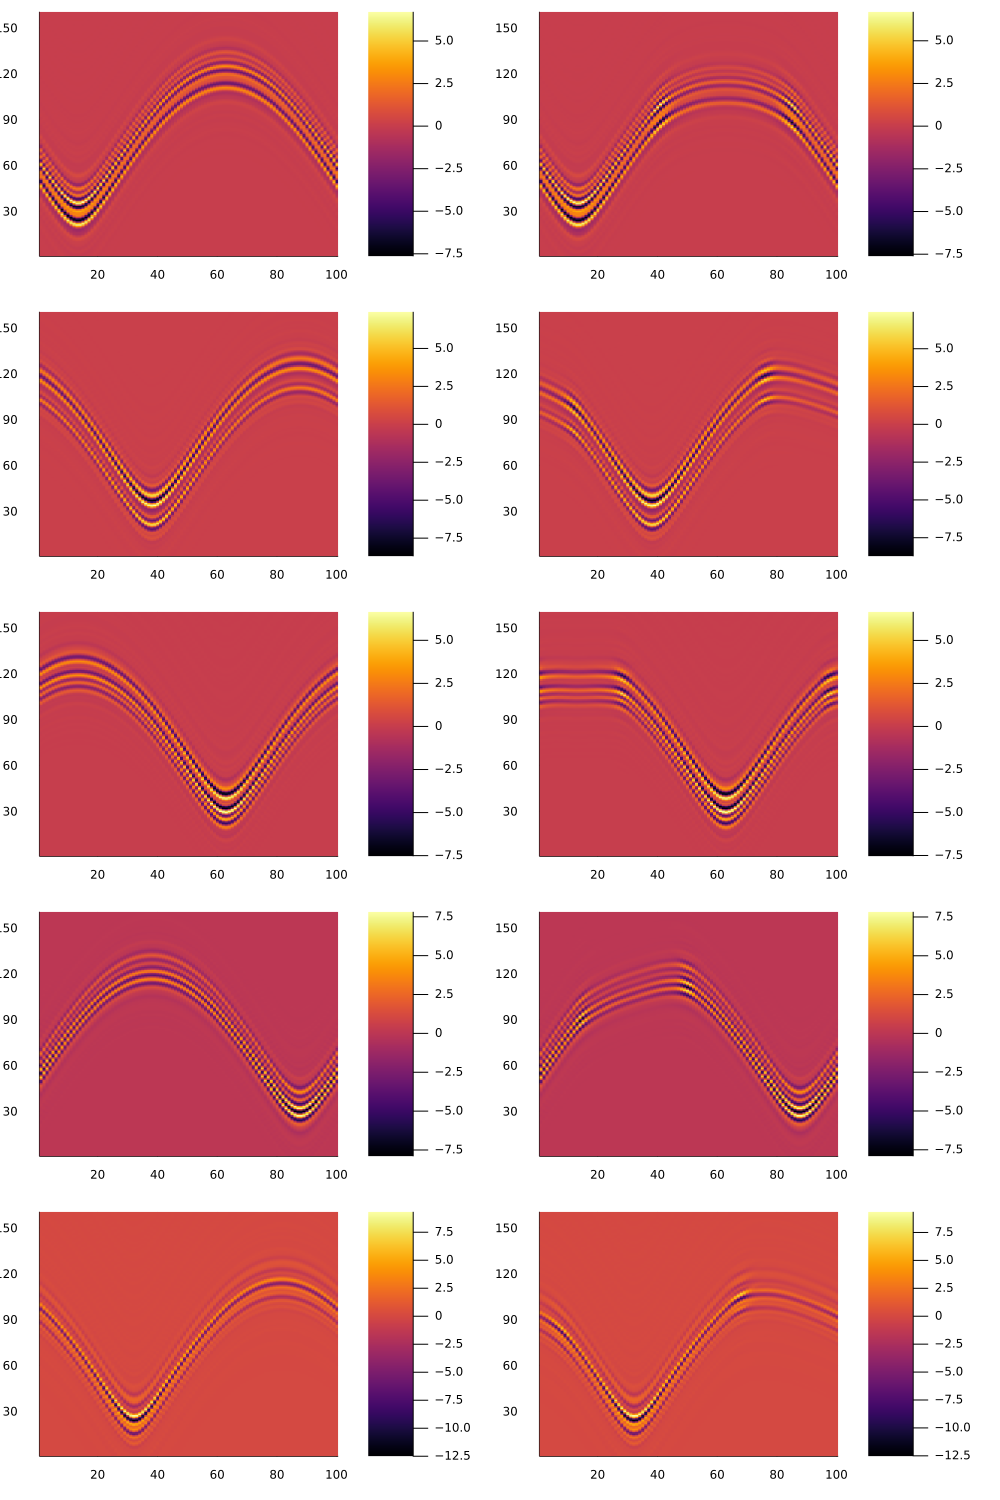

In [10]:
plot([heatmap(Xotest[:,:,j,i]) for i in 1:2, j in 1:5]..., layout=(5,2),size=(1000,1500))

In [11]:
Xotest=reshape(Xotest, 1,size(Xotest)...);

h5open(string("../test2seismicTL_circular2.h5"),"w") do file
    file["data"]=Float32.(Xotest)
end

1×160×100×20×2 Array{Float32, 5}:
[:, :, 1, 1, 1] =
 -0.00192173  0.000145903  0.00903196  0.0192654  …  -0.00947409  -0.00748698

[:, :, 2, 1, 1] =
 0.0186511  0.0210225  0.0135449  0.00374785  …  0.000201668  0.000562848

[:, :, 3, 1, 1] =
 0.00597383  -0.00432519  -0.00404702  …  0.000909463  0.00430194  0.0074742

...

[:, :, 98, 1, 1] =
 -0.000316677  -0.000313811  …  0.00688835  0.00492945  0.000633201

[:, :, 99, 1, 1] =
 -0.000285387  -0.000425941  …  0.00141365  0.00470736  0.0035071

[:, :, 100, 1, 1] =
 -0.00192173  0.000145903  0.00903196  0.0192654  …  -0.00947409  -0.00748698

[:, :, 1, 2, 1] =
 0.000350833  0.000350833  0.000350833  …  0.0136701  0.00315857  -0.0147851

[:, :, 2, 2, 1] =
 0.000350833  0.000350833  …  -0.00309966  -0.0177454  -0.0137365

[:, :, 3, 2, 1] =
 0.000350833  0.000350833  …  -0.017895  -0.00816844  -0.00035574

...

[:, :, 98, 2, 1] =
 0.000350833  0.000350833  0.000350833  …  0.0197671  0.0159707  0.014542

[:, :, 99, 2, 1] =
 0.000350833  0.00